## Tweet Sentiment Analysis: Exploring Temporal Patterns

This project is a short exploratory data analysis (EDA) that investigates how the sentiment of tweets changes over different periods of time, such as days, weeks, and months. The goal of this project is to gain insights into how tweet sentiment varies over time and potentially identify any interesting patterns or trends.


### <u>Packages and Imports</u>

In [ ]:
!pip install transformers
!pip install scipy
!pip install torch torchvision 
!pip install matplotlib
# Runtime might need restarting after this installation.
!pip install tdqm
!pip install seaborn
!pip install scikit-posthocs
!pip install twitscrape
# twitscrape is a package I created as an aside to this project to further bolster my learning (https://github.com/christywastaken/twitscrape, https://pypi.org/project/twitscrape). 
# I'm sure there are more effective ways of collecting the tweet data used in this project. If you are looking to repeat this data analysis I would reccomend looking for another package such as snscrape.

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

import sqlite3
import pandas as pd
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoConfig
from transformers import logging
from scipy.special import softmax
from tqdm.auto import tqdm
from datetime import datetime
from twitscrape.twitter_scraper import TwitterGeolocationScraper 
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import shapiro
from scipy.stats import kruskal
import scikit_posthocs as sp

### <u>Functions</u>

In [4]:
import sqlite3

class SQLContextManager():
    """ Context manager for SQL db """
    def __init__(self, host):
        self.connection = None
        self.host = host

    def __enter__(self):
        self.connection = sqlite3.connect(self.host)
        return self.connection
        
    def __exit__(self, exc_type, exc_val, exc_tab):
        self.connection.commit()
        self.connection.close()
        
        

In [5]:
import pandas as pd
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoConfig
from transformers import logging
from scipy.special import softmax
import numpy as np
from tqdm.auto import tqdm


class SentimentAnalysis():
    
    def __init__(self):
        logging.set_verbosity_error()
        self.MODEL = f"cardiffnlp/twitter-roberta-base-sentiment-latest"
        # This is a RoBERTa-base model trained on ~124M tweets from January 2018 to December 2021, and finetuned for sentiment analysis with the TweetEval benchmark.
        self.tokenizer = AutoTokenizer.from_pretrained(self.MODEL)
        self.config = AutoConfig.from_pretrained(self.MODEL)
        self.model = AutoModelForSequenceClassification.from_pretrained(self.MODEL)
        

    def preprocess(self, text):
        new_text = []
        for t in text.split(" "):
            t = '@user' if t.startswith('@') and len(t) > 1 else t
            t = 'http' if t.startswith('http') else t
            new_text.append(t)
        return " ".join(new_text)


    def analyse_sentiment(self, tweet_df: pd.DataFrame) -> pd.DataFrame:
        """ Analyses the sentiment of tweets and returns a dataframe with new columns 'negative', 'neutral' and 'positive' """
        print('Running sentiment analysis. This could take a while.')
        tweet_df_copy = tweet_df.copy()
        for index, row in tqdm(tweet_df_copy.iterrows(), total=tweet_df_copy.shape[0]):
            try:
                tweet_text = row['tweet_text']
                tweet_text = self.preprocess(tweet_text)
                encoded_input = self.tokenizer(tweet_text, return_tensors='pt')
                output = self.model(**encoded_input)
                scores = output[0][0].detach().numpy()
                scores = softmax(scores)
                scores = np.round(scores.astype(float), 4)
                sentiment_dict = {self.config.id2label[i]: score for i, score in enumerate(scores)}
                for column, value in sentiment_dict.items():
                    tweet_df_copy.at[index, column] = value
                # print(f'tweet: {tweet_text} | senti: {sentiment_dict}')
            except Exception as err:
                print(f'Error at index:{index} | Error: {err}')
        return tweet_df_copy

    


In [6]:
# Adding epoch time (s) to the dataframe
import pandas as pd
from datetime import datetime

def add_epoch_time_and_sort(tweet_df: pd.DataFrame) -> pd.DataFrame:
    """ Adds epoch_seconds column to df and sorts by epoch_seconds ascending """
    
    tweet_df_copy = tweet_df.copy()
    date_format = "%a %b %d %H:%M:%S %z %Y"

    for index, row in tweet_df_copy.iterrows():
        try:
            created_at = row['created_at']
            epoch_seconds = datetime.strptime(created_at, date_format).timestamp()
            tweet_df_copy.at[index, 'epoch_seconds'] = epoch_seconds
        except Exception as err:
            print(f'Error: {err}')
    tweet_df_copy.sort_values(by='epoch_seconds', inplace=True, ignore_index=True)
    tweet_df_copy.reset_index(inplace=True, drop=True)
    return tweet_df_copy


In [7]:
# Testing whether data is missing
import pandas as pd

def check_gaps_in_data(tweet_df: pd.DataFrame) -> pd.DataFrame:
    """ Adds time_diff_mins coloumn to df which can be used for identifying holes in data. This column is the time betweent the current and next tweet """
    tweet_df_copy = tweet_df.copy()
    
    largest_time_diff = 0.0
    index_largest_diff = 0
    for index, row in tweet_df_copy.iterrows():
        try:
            epoch_seconds1 = tweet_df_copy.iloc[index]['epoch_seconds']
            epoch_seconds2 = tweet_df_copy.iloc[index+1]['epoch_seconds']
            
            time_diff = epoch_seconds2 - epoch_seconds1
            time_diff_mins = round((time_diff / 60), 2)
            if time_diff_mins > largest_time_diff:
                largest_time_diff = time_diff_mins
                index_largest_diff = index
            tweet_df_copy.at[index, 'time_diff_mins'] = time_diff_mins
            

        except Exception as err:
            print(f'Error: {err}')
    print(f'-- The largest gap in data is: {largest_time_diff} mins at index: {index_largest_diff} --')
    return tweet_df_copy






### <u>Scraping Tweets</u>

In [10]:

from twitscrape.twitter_scraper import TwitterGeolocationScraper 
# twitscrape is a package I built and distributed as an aside, learning experiment to this project. I plan to work on it further so the import method might change from the above.
# Source code included in twitter_scraper.py 
# https://github.com/christywastaken/twitscrape 
# https://pypi.org/project/twitscrape/ 

newcastle_latitude = 54.975029
newcastle_longitude = -1.612477
search_radius_km = 15.0
twitter_scraper = TwitterGeolocationScraper(start_date='2020-01-01', end_date='2021-01-01', latitude=newcastle_latitude, longitude=newcastle_longitude, radius=search_radius_km, filter_links=True, filter_replies=True, is_headless=True)
tweet_df_2020 = twitter_scraper.run()
# Creates dataframe of all the tweets in Newcastle-Upon-Tyne for a 15km radius for all of 2020. No replies or tweets containing media included.

#Store DF to SQL DB
with SQLContextManager('twitter_sentiment_analysis.db') as connection:
    tweet_df_2020.to_sql('all_2020_2', connection, if_exists='replace', index=False)




-- TwitterGeolocationScraper running. This may take a minute to update the webdriver. --
Page loading not complete
Tweets Scraped: 20
Tweets Scraped: 40
Tweets Scraped: 60
Tweets Scraped: 80
Tweets Scraped: 100
Tweets Scraped: 120
Tweets Scraped: 140
Tweets Scraped: 160
Tweets Scraped: 180
Tweets Scraped: 200
Tweets Scraped: 220
Tweets Scraped: 240
Tweets Scraped: 260
Tweets Scraped: 280
Tweets Scraped: 300
Tweets Scraped: 320
Tweets Scraped: 340
Tweets Scraped: 360
Tweets Scraped: 380
Tweets Scraped: 400
Tweets Scraped: 420
Tweets Scraped: 440
Tweets Scraped: 460
Tweets Scraped: 480
Tweets Scraped: 500
Tweets Scraped: 520
Tweets Scraped: 540
Tweets Scraped: 560
Tweets Scraped: 580
Tweets Scraped: 600
Tweets Scraped: 620
Tweets Scraped: 640
Tweets Scraped: 660
Tweets Scraped: 680
Tweets Scraped: 700
Tweets Scraped: 720
Tweets Scraped: 740
Tweets Scraped: 760
Tweets Scraped: 780
Tweets Scraped: 800
Tweets Scraped: 820
Tweets Scraped: 840
Tweets Scraped: 860
Tweets Scraped: 880
Tweets Sc

### <u>Sorting Data</u>

In [11]:
# Add epoch_seconds to SQL db.
with SQLContextManager('twitter_sentiment_analysis.db') as connection:
    query = "SELECT * FROM all_2020_2"
    tweet_df_2020 = pd.read_sql(query, connection)
    epoch_tweet_df_2020 = add_epoch_time_and_sort(tweet_df=tweet_df_2020)
    epoch_tweet_df_2020.to_sql('all_2020_2', con=connection, if_exists='replace', index=False)



### <u>Identifying Gaps in Data<u/>

In [12]:
# check for gaps in data and sort by largest gaps.

tweet_df_time_gaps_2020 = check_gaps_in_data(epoch_tweet_df_2020)
tweet_df_time_gaps_2020.sort_values(by='time_diff_mins', inplace=True, ascending=False)

tweet_df_time_gaps_2020.head(10)


Error: single positional indexer is out-of-bounds
-- The largest gap in data is: 343.23 mins at index: 68630 --


,tweet_id,user_id,created_at,tweet_text,hashtags,media_url,retweet_count,favourite_count,reply_count,views,epoch_seconds,time_diff_mins
68630,1323429993821687808,1057980006,Tue Nov 03 01:01:13 +0000 2020,Time for #RAW,RAW,None,0,0,0,None,1.604365e+09,343.23
38049,1268705417196187648,300943766,Fri Jun 05 00:45:17 +0000 2020,Chicken pakoras from the indians far nicer tha...,None,None,0,1,0,None,1.591318e+09,340.62
38212,1269086175056269315,1057980006,Sat Jun 06 01:58:17 +0000 2020,Yes!!!!!!!! Sasha!!!!!!!!! New Tag Champs!!!!!...,SmackDown,None,0,0,0,None,1.591409e+09,315.25
68205,1322717474710867969,20694134,Sun Nov 01 01:49:55 +0000 2020,Absolute class show of respect from both fight...,UFCVegas12|SilvaHall,None,0,0,0,None,1.604195e+09,294.42
51363,1291179804193099776,923577566,Thu Aug 06 01:10:28 +0000 2020,"This club is our club,\nMade out of two clubs,...",MasterIsASlimeyBastard|PremierLeagueIsCorrupt|...,None,0,0,0,None,1.596676e+09,288.20
13766,1234289537045712896,4825634675,Mon Mar 02 01:28:52 +0000 2020,Penny Duncan is lowkey the funniest person I k...,None,None,0,2,0,None,1.583113e+09,285.75
74344,1333945359459086337,1106871343,Wed Dec 02 01:25:31 +0000 2020,Can’t wait for karaoke,None,None,0,0,0,None,1.606872e+09,281.02
60006,1307846680662945792,611577887,Mon Sep 21 00:58:41 +0000 2020,Rapping like m 'n' m......😎😎\n💿🎶🎙️🎙️🎙️🔌📱🎤,None,None,0,0,0,None,1.600650e+09,280.23
79631,1343361371673681920,22682758,Mon Dec 28 01:01:24 +0000 2020,We’re lucky to still have Laurie Taylor and #B...,BBCThinkingAllowed,None,0,1,0,None,1.609117e+09,279.72
75644,1336853574190559232,736347946816540672,Thu Dec 10 02:01:44 +0000 2020,Okay I'm gna try n get my body to sleep rip,None,None,0,0,1,None,1.607566e+09,274.58


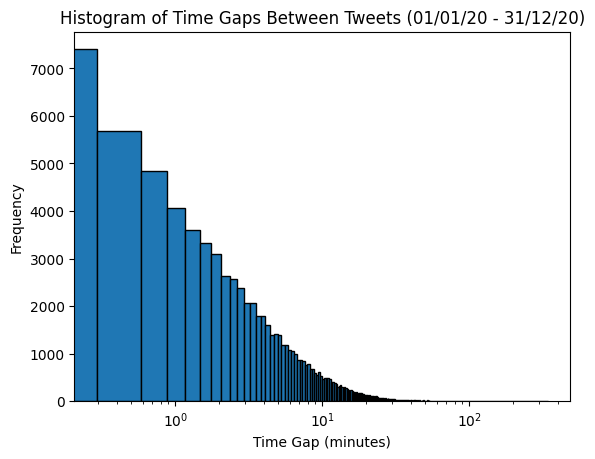

In [13]:
# visiualizing gaps in the data 
import matplotlib.pyplot as plt

plt.hist(tweet_df_time_gaps_2020['time_diff_mins'], bins='auto', edgecolor='black')
plt.title('Histogram of Time Gaps Between Tweets (01/01/20 - 31/12/20)')
plt.xlabel('Time Gap (minutes)')
plt.ylabel('Frequency')
plt.xscale('log')
plt.show()


In [14]:
# Getting some numbers on the gaps in the data
data_size = len(tweet_df_time_gaps_2020)
for time in [60,120,360,420]:
    num_gaps = sum(tweet_df_time_gaps_2020['time_diff_mins']>time)
    print(f'Percentage of tweets with gap >{str(time)} mins: {round(((num_gaps/data_size)*100),4)}%')


Percentage of tweets with gap >60 mins: 0.8496%
Percentage of tweets with gap >120 mins: 0.2422%
Percentage of tweets with gap >360 mins: 0.0%
Percentage of tweets with gap >420 mins: 0.0%


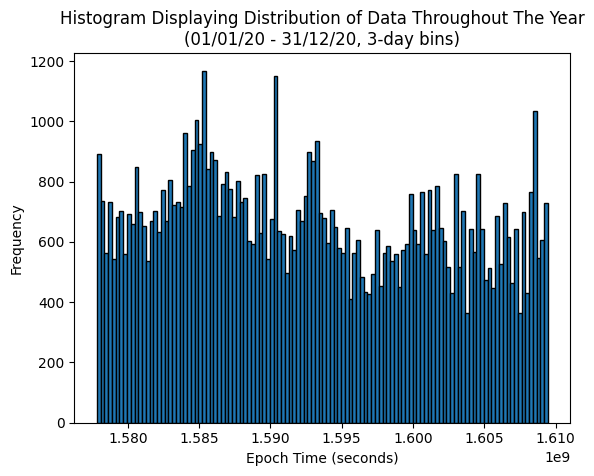

In [15]:
# Visualising spread of data using epoch time in seconds.
plt.hist(tweet_df_time_gaps_2020['epoch_seconds'], bins=120,edgecolor='black')
plt.title('Histogram Displaying Distribution of Data Throughout The Year\n(01/01/20 - 31/12/20, 3-day bins)')
plt.xlabel('Epoch Time (seconds)')
plt.ylabel('Frequency')
plt.show()

### <u>Sentiment Analysis</u>

In [16]:
# analyse the sentiment of the data. 
with SQLContextManager('twitter_sentiment_analysis.db') as connection:
    query = "SELECT * FROM all_2020_2"
    tweet_df_2020 = pd.read_sql(query, connection)
    sentiment_tweet_df_2020 = SentimentAnalysis().analyse_sentiment(tweet_df=tweet_df_2020)
    sentiment_tweet_df_2020.to_sql('all_2020_sentiment_2', connection, if_exists='replace', index=False)

Running sentiment analysis. This could take a while.


 80%|███████▉  | 64004/80504 [2:21:11<30:30,  9.01it/s]  

Error at index:64001 | Error: The expanded size of the tensor (611) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 611].  Tensor sizes: [1, 514]


100%|██████████| 80504/80504 [2:56:24<00:00,  7.61it/s]  


### <u>Removing Tweets That Could Not Be Analysed</u>

In [17]:
# Looking into error-causing tweets.

print(sentiment_tweet_df_2020.iloc[64001]['tweet_text'])



All we are saying
👇🏿👇🏿👇🏿👇🏿👇🏿👇🏿👇🏿👇🏿👇🏿👇🏿👇🏿
👉🏿👇🏾👇🏾👇🏾👇🏾👇🏾👇🏾👇🏾👇🏾👇🏾👈🏿
👉🏿👉🏾👇🏽👇🏽👇🏽👇🏽👇🏽👇🏽👇🏽👈🏾👈🏿
👉🏿👉🏾👉🏽👇🏼👇🏼👇🏼👇🏼👇🏼👈🏽👈🏾👈🏿
👉🏿👉🏾👉🏽👉🏼👇🏻👇🏻👇🏻👈🏼👈🏽👈🏾👈🏿
👉🏿👉🏾👉🏽👉🏽#EndSARS👈🏽👈🏽👈🏾👈🏿
👉🏿👉🏾👉🏽👉🏼👆🏻👆🏻👆🏻👈🏼👈🏽👈🏾👈🏿
👉🏿👉🏾👉🏽👆🏼👆🏼👆🏼👆🏼👆🏼👈🏽👈🏾👈🏿
👉🏿👉🏾👆🏽👆🏽👆🏽👆🏽👆🏽👆🏽👆🏽👈🏾👈🏿
👉🏿👆🏾👆🏾👆🏾👆🏾👆🏾👆🏾👆🏾👆🏾👆🏾👈🏿
👉🏿👆🏿👆🏿👆🏿👆🏿👆🏿👆🏿👆🏿👆🏿👆🏿👈🏿


In [18]:

# Drop rows with missing sentiment data.
sentiment_tweet_df_2020.dropna(subset=['negative', 'neutral', 'positive'], inplace=True)

#Save to SQL
with SQLContextManager('twitter_sentiment_analysis.db') as connection:
    sentiment_tweet_df_2020.to_sql('all_2022_sentiment_2', connection, if_exists='replace', index=False)

### <u>Visualizing Distribution of Sentiment</u>

In [19]:
sentiment_tweet_df_2020.head(5)


,tweet_id,user_id,created_at,tweet_text,hashtags,media_url,retweet_count,favourite_count,reply_count,views,epoch_seconds,negative,neutral,positive
0,1212161567120338945,14284095,Wed Jan 01 00:00:13 +0000 2020,Happy New Year! Welcome to the 2020s.,None,None,0,21,2,None,1.577837e+09,0.0029,0.0111,0.9859
1,1212161978015371264,3013161862,Wed Jan 01 00:01:51 +0000 2020,Happy New Year everyone,None,None,0,19,6,None,1.577837e+09,0.0080,0.0280,0.9641
2,1212162136300048391,226312599,Wed Jan 01 00:02:28 +0000 2020,Happy new year to all the porn and gambling bo...,None,None,0,0,0,None,1.577837e+09,0.0821,0.2214,0.6965
3,1212162175755784194,2149510271,Wed Jan 01 00:02:38 +0000 2020,"Happy New Year to my UK friends, to those who'...",None,None,0,18,3,None,1.577837e+09,0.0031,0.0137,0.9832
4,1212162213005451265,1067246391255281666,Wed Jan 01 00:02:47 +0000 2020,"Happy New Year everyone. Peace, Love and Happi...",None,None,0,2,0,None,1.577837e+09,0.0038,0.0112,0.9850


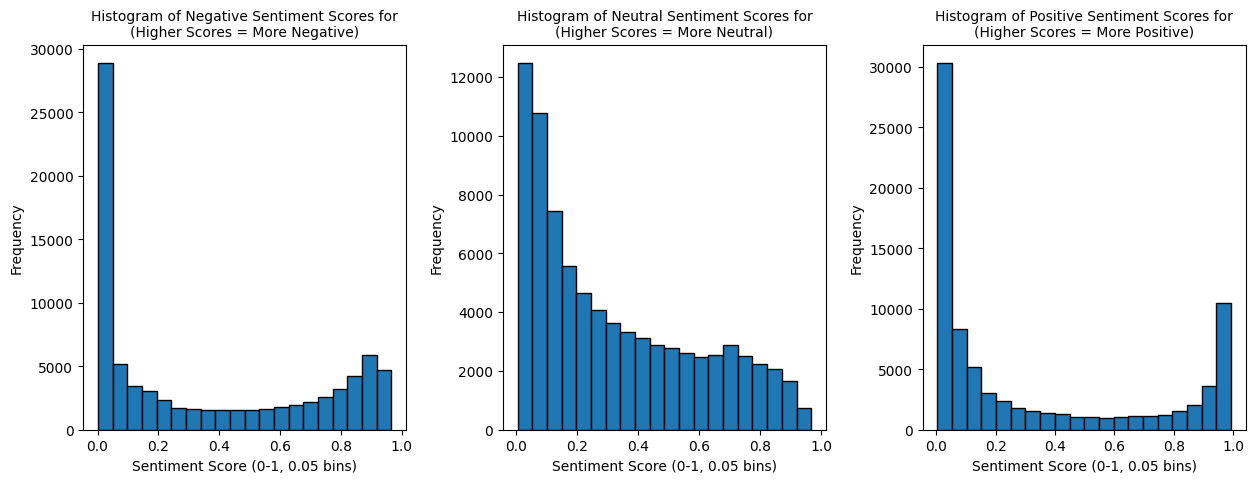

In [20]:
# Frequency distribution for positive, negative and neutral sentiments of tweets
# Note: this could be systematically skewed by the model used or Twitter removing negative tweets.

fig, axes = plt.subplots(1,3, figsize=(15,5))

sentiment_list = ['negative', 'neutral', 'positive']
for i, sentiment in enumerate(sentiment_list):
    axes[i].hist(sentiment_tweet_df_2020[sentiment], bins=20, edgecolor='black')
    axes[i].set_title(f'Histogram of {sentiment.capitalize()} Sentiment Scores for\n(Higher Scores = More {sentiment.capitalize()})', fontsize=10)
    axes[i].set_xlabel('Sentiment Score (0-1, 0.05 bins)')
    axes[i].set_ylabel('Frequency')


plt.subplots_adjust(wspace=0.3)
plt.show()

#### It is possible that the negative sentiment data is truncated at the higher end (near 1) because extremely negative tweets (such as those containing racism or hate speech) could be removed by Twitter. Conversely, I doubt that overly positive tweets would be removed.

### <u>Cleaning Data</u>

In [21]:
# Removing timezone info
with SQLContextManager('twitter_sentiment_analysis.db') as connection:
    query = "SELECT * FROM all_2020_sentiment_2"
    sentiment_df_2020 = pd.read_sql(query, connection)
    sentiment_df_2020['created_at'] = pd.to_datetime(sentiment_df_2020['created_at']).dt.tz_localize(None)
    sentiment_df_2020.to_sql('all_2020_sentiment_2', connection,if_exists='replace', index=False)

In [22]:

# Get df with only created_at and sentiment.
with SQLContextManager('twitter_sentiment_analysis.db') as connection:
    query = "SELECT created_at, negative, neutral, positive FROM all_2020_sentiment_2"
    sentiment_df_2020 = pd.read_sql(query, connection)

sentiment_df_2020.head(5)

,created_at,negative,neutral,positive
0,2020-01-01 00:00:13,0.0029,0.0111,0.9859
1,2020-01-01 00:01:51,0.0080,0.0280,0.9641
2,2020-01-01 00:02:28,0.0821,0.2214,0.6965
3,2020-01-01 00:02:38,0.0031,0.0137,0.9832
4,2020-01-01 00:02:47,0.0038,0.0112,0.9850


### <u>Visualising How Sentiment Changes in Different Time Periods For 2020</u>

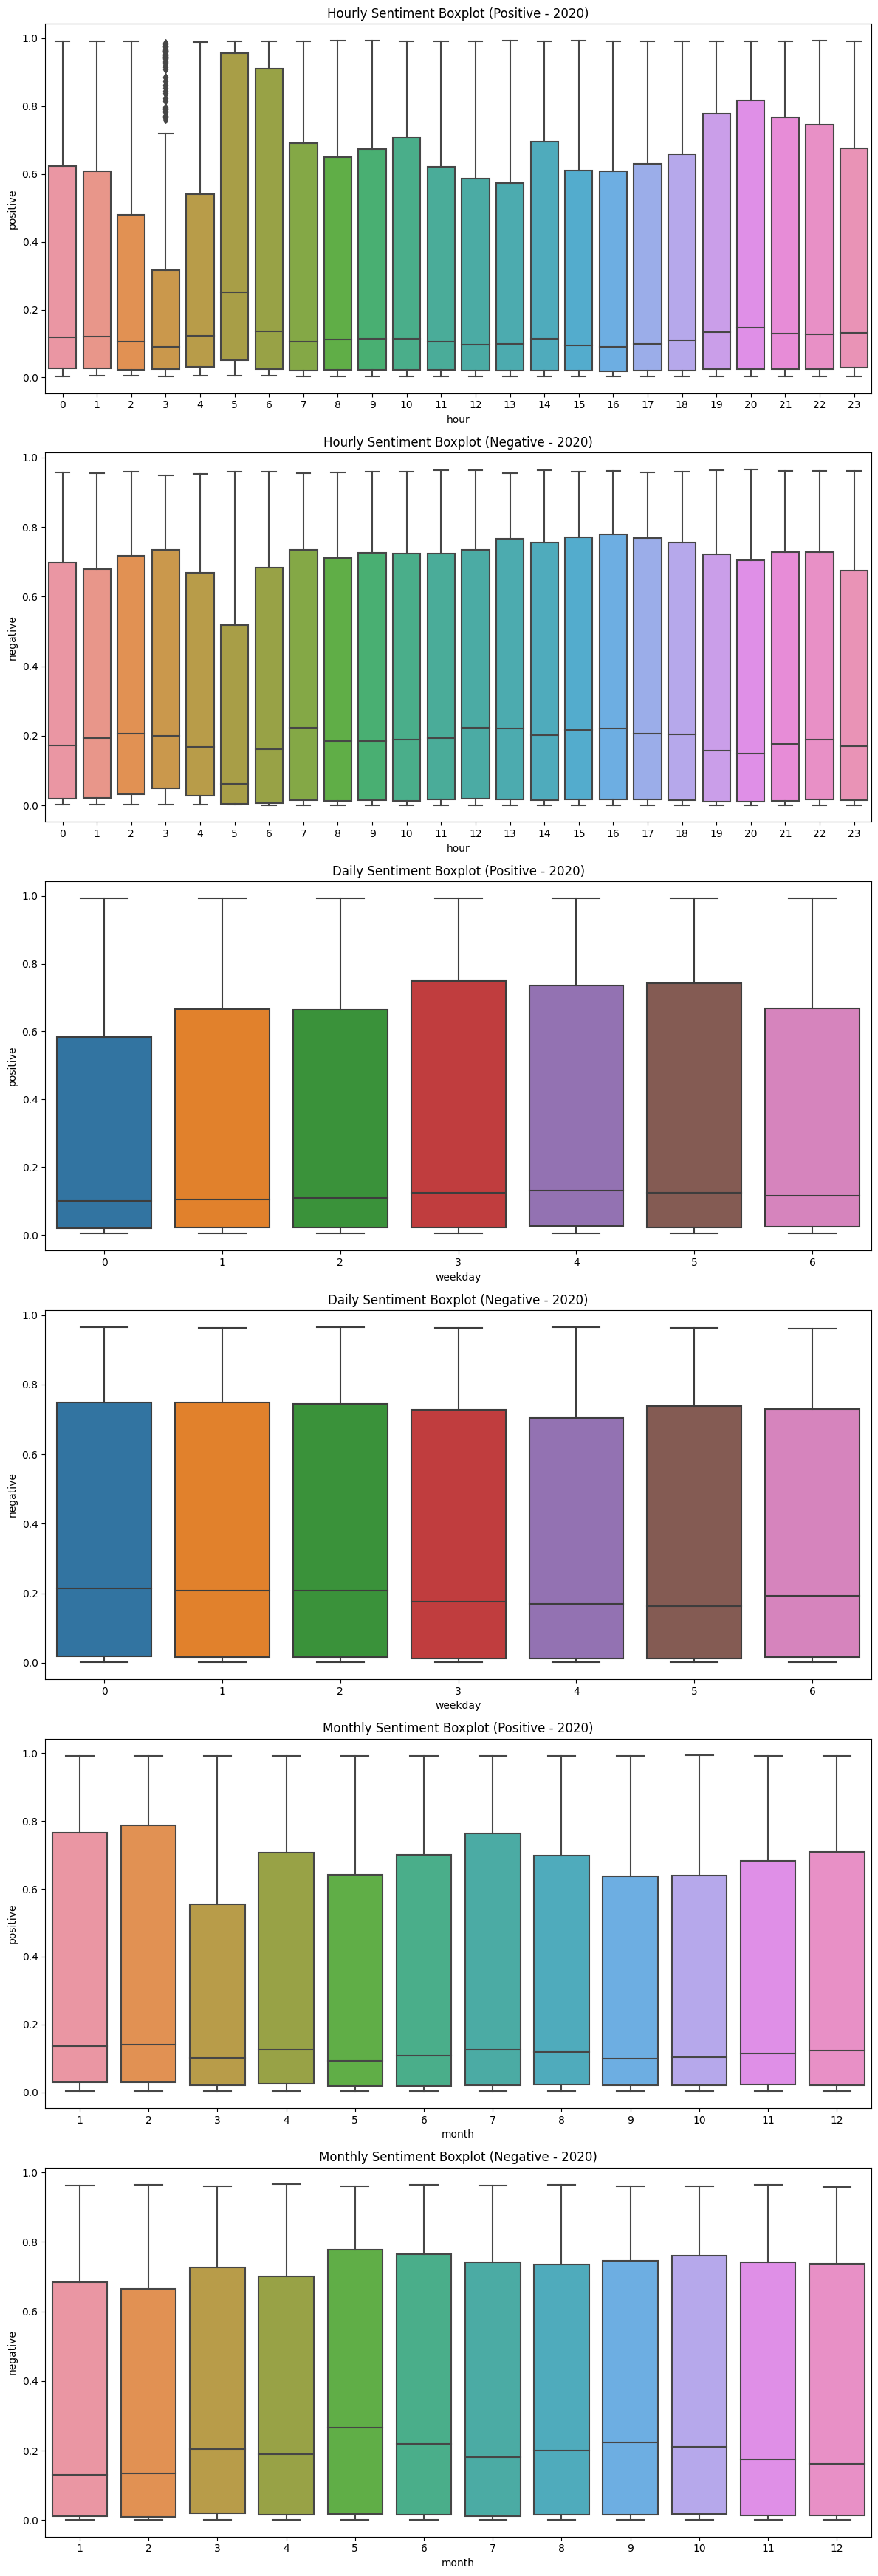

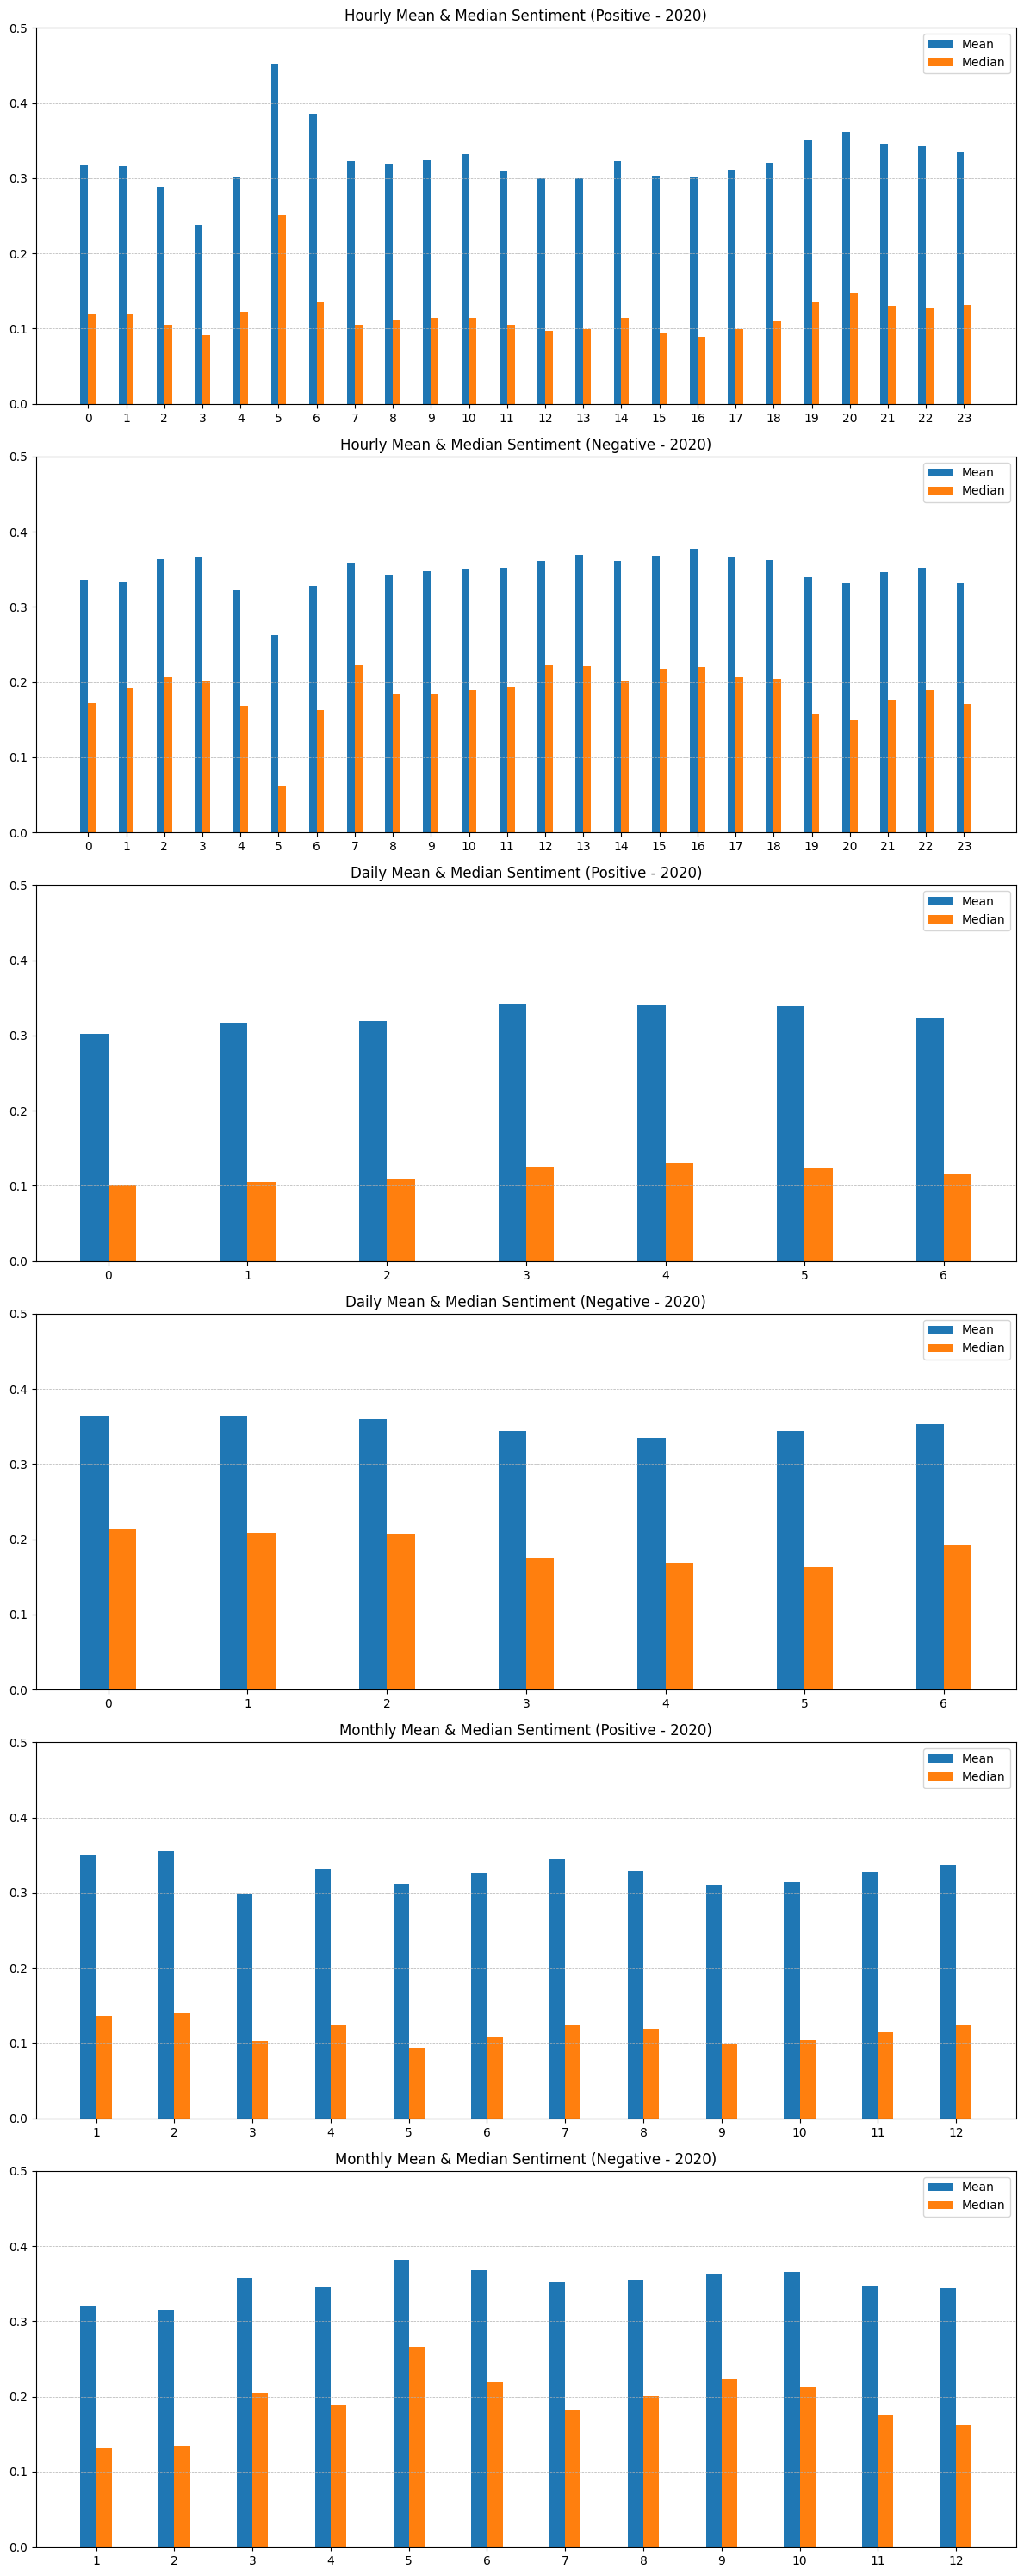

In [23]:
import numpy as np
import seaborn as sns
sentiment_df_2020['created_at'] = pd.to_datetime(sentiment_df_2020['created_at'])
sentiment_df_2020['hour'] = sentiment_df_2020['created_at'].dt.hour
sentiment_df_2020['weekday'] = sentiment_df_2020['created_at'].dt.weekday
sentiment_df_2020['month'] = sentiment_df_2020['created_at'].dt.month

fig, axes = plt.subplots(6,1,figsize=(12,35))

period_list = ['hour', 'weekday', 'month']
sentiment_list = ['positive', 'negative']

i = 0
for period in period_list:
    for sentiment in sentiment_list:
        sns.boxplot(x=period, y=sentiment, data=sentiment_df_2020, ax=axes[i])
        axes[i].set_title(f'{period.capitalize()}ly Sentiment Boxplot ({sentiment.capitalize()} - 2020)')
        i += 1

axes[2].set_title('Daily Sentiment Boxplot (Positive - 2020)')
axes[3].set_title('Daily Sentiment Boxplot (Negative - 2020)')

plt.tight_layout()
plt.show()


fig, axes = plt.subplots(6,1,figsize=(12,30))
i = 0 
for period in period_list:
    grouped_mean = sentiment_df_2020.groupby(period).mean(numeric_only=True)
    grouped_median = sentiment_df_2020.groupby(period).median(numeric_only=True)
    index = grouped_mean.index
    x = np.arange(len(index))
    width = 0.2
    for sentiment in sentiment_list:
        mean_values = grouped_mean[sentiment]
        median_values = grouped_median[sentiment]
        axes[i].bar(x - width/2, mean_values, width, label='Mean')
        axes[i].bar(x + width/2, median_values, width, label='Median')
        axes[i].set_title(f'{period.capitalize()}ly Mean & Median Sentiment ({sentiment.capitalize()} - 2020)')
        axes[i].set_xticks(x)
        axes[i].set_xticklabels(index)
        axes[i].yaxis.grid(True, linestyle='--', linewidth=0.5)
        axes[i].set_ylim(0.0,0.5)
        axes[i].legend()
        i += 1

axes[2].set_title('Daily Mean & Median Sentiment (Positive - 2020)')
axes[3].set_title('Daily Mean & Median Sentiment (Negative - 2020)')
plt.tight_layout()
plt.show()


There is an interesting jump in positive sentiment around 5am which is quite interesting. I will explore the significane of this below.

In [24]:
sentiment_df_2020
filtered_hour_only_df = sentiment_df_2020.drop(columns=['weekday', 'month', 'neutral'])

filtered_df_3_to_5_am = filtered_hour_only_df[filtered_hour_only_df['hour'].isin([3,4,5])]


print(f'Correlation between 3am and 5am:\n{filtered_df_3_to_5_am.corr(numeric_only=True)}\n')


Correlation between 3am and 5am:
          negative  positive      hour
negative  1.000000 -0.700216 -0.134266
positive -0.700216  1.000000  0.246861
hour     -0.134266  0.246861  1.000000



#####  There is an inverse correlation (-0.7) between positive and negative sentiment between 3am and 5am

### <u>Calculating the Normality and Variance of Sentiment Between 3am and 5am</u>

In [25]:
# Testing for normality 
from scipy.stats import shapiro
alpha = 0.05
sentiment_list = ['positive', 'negative']
period_list = [3,4,5]

for sentiment in sentiment_list:
    for period in period_list:
        df = filtered_hour_only_df[filtered_hour_only_df['hour'] == period]
        sentiment_data = df[sentiment]
        test_result = shapiro(sentiment_data)
        print(f'Shapiro-Wilk Test for {sentiment.capitalize()} sentiment at {str(period)} AM: ', test_result)
        if test_result.pvalue < alpha:
            print(f'{sentiment.capitalize()} Sentiment Data for {str(period)}am does not follow a normal distribution\n')
        else:
            print(f'{sentiment.capitalize()} Sentiment Data for {str(period)}am does follow a normal distribution.\n')




Shapiro-Wilk Test for Positive sentiment at 3 AM:  ShapiroResult(statistic=0.7311924695968628, pvalue=8.456143051187121e-28)
Positive Sentiment Data for 3am does not follow a normal distribution

Shapiro-Wilk Test for Positive sentiment at 4 AM:  ShapiroResult(statistic=0.7629300355911255, pvalue=1.1945825606262176e-23)
Positive Sentiment Data for 4am does not follow a normal distribution

Shapiro-Wilk Test for Positive sentiment at 5 AM:  ShapiroResult(statistic=0.7826024889945984, pvalue=1.3777326055479262e-30)
Positive Sentiment Data for 5am does not follow a normal distribution

Shapiro-Wilk Test for Negative sentiment at 3 AM:  ShapiroResult(statistic=0.8359497785568237, pvalue=1.8837573062877667e-22)
Negative Sentiment Data for 3am does not follow a normal distribution

Shapiro-Wilk Test for Negative sentiment at 4 AM:  ShapiroResult(statistic=0.8078887462615967, pvalue=1.6165692089216472e-21)
Negative Sentiment Data for 4am does not follow a normal distribution

Shapiro-Wilk Tes

In [27]:
# Calculating variance. 
sentiment_list = ['positive', 'negative']
period_list = [3,4,5]

for sentiment in sentiment_list:
    for period in period_list:
        df = filtered_hour_only_df[filtered_hour_only_df['hour'] == period]
        sentiment_data = df[sentiment]
        variance = np.var(sentiment_data, ddof=0)
        print(f'Variance for {sentiment} sentiment at {period}am is: {variance}')



Variance for positive sentiment at 3am is: 0.09290292636166647
Variance for positive sentiment at 4am is: 0.12190334683745452
Variance for positive sentiment at 5am is: 0.17184143587950138
Variance for negative sentiment at 3am is: 0.11916057330820193
Variance for negative sentiment at 4am is: 0.11397719899488874
Variance for negative sentiment at 5am is: 0.10900146248968144


### <u>Visulaising the Distribution of Sentiment Between 3am and 5am</u>

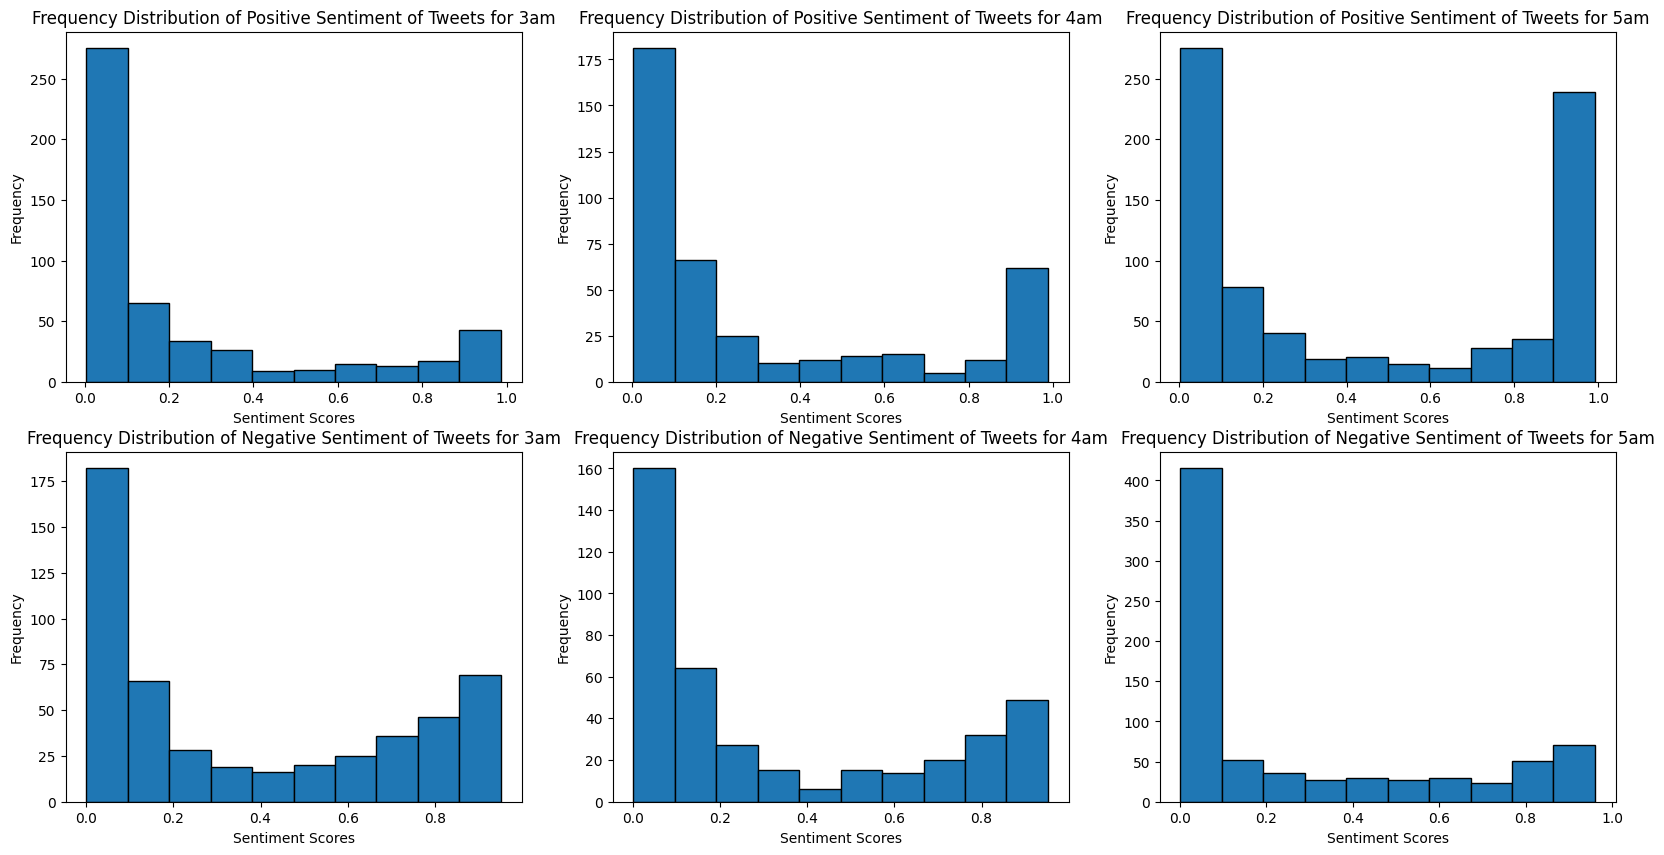

In [28]:

fig, axes = plt.subplots(2,3,figsize=(20,10))
sentiment_list = ['positive', 'negative']
period_list = [3,4,5]
i = 0
for row, sentiment in enumerate(sentiment_list):
    for col, period in enumerate(period_list):
        df = filtered_hour_only_df[filtered_hour_only_df['hour'] == period]
        axes[row, col].hist(df[sentiment], bins=10, edgecolor='black')
        axes[row, col].set_title(f'Frequency Distribution of {sentiment.capitalize()} Sentiment of Tweets for {str(period)}am')
        axes[row, col].set_ylabel('Frequency')
        axes[row, col].set_xlabel('Sentiment Scores')

### <u>Testing for Significance Between the Sentiment Data for 3am, 4am and 5am</u>

##### Significance testing using a Kruskal-Wallis H-test as the data is not normally distributed. 

In [29]:
from scipy.stats import kruskal

sentiment_3am = filtered_hour_only_df[filtered_hour_only_df['hour'] == 3]
sentiment_4am = filtered_hour_only_df[filtered_hour_only_df['hour'] == 4]
sentiment_5am = filtered_hour_only_df[filtered_hour_only_df['hour'] == 5]
sentiment_list = ['positive', 'negative']

for sentiment in sentiment_list:
    result = kruskal(sentiment_3am[sentiment], sentiment_4am[sentiment], sentiment_5am[sentiment])
    print(f'Kruskal-Wallis H-test result for {sentiment} sentiment: {result}')
    if result.pvalue < 0.05:
        print(f'There is a significant difference between the median {sentiment} sentiments of tweets between 3am, 4am and 5am.\n')
    else: 
        print(f'There is no significant difference between the median {sentiment} sentiments of tweets between 3am, 4am and 5am.\n')



Kruskal-Wallis H-test result for positive sentiment: KruskalResult(statistic=82.34276834059114, pvalue=1.316724882200847e-18)
There is a significant difference between the median positive sentiments of tweets between 3am, 4am and 5am.

Kruskal-Wallis H-test result for negative sentiment: KruskalResult(statistic=71.1447807767852, pvalue=3.5571906835943734e-16)
There is a significant difference between the median negative sentiments of tweets between 3am, 4am and 5am.



In [37]:
import scikit_posthocs as sp
sentiment_list = ['positive', 'negative']
for sentiment in sentiment_list:
    sentiment_data = filtered_hour_only_df[filtered_hour_only_df['hour'].isin([3, 4, 5])][['hour', sentiment]]

    dunn_result = sp.posthoc_dunn(sentiment_data, val_col=sentiment, group_col='hour', p_adjust='bonferroni')
    print(f"Dunn's test result for {sentiment} sentiment:\n{dunn_result}\n")
    

Dunn's test result for positive sentiment:
              3             4             5
3  1.000000e+00  3.248785e-02  5.010763e-18
4  3.248785e-02  1.000000e+00  1.975673e-07
5  5.010763e-18  1.975673e-07  1.000000e+00

Dunn's test result for negative sentiment:
              3             4             5
3  1.000000e+00  1.109447e-01  1.947541e-15
4  1.109447e-01  1.000000e+00  4.471186e-07
5  1.947541e-15  4.471186e-07  1.000000e+00



### <u>Conclusions - Sentiment of Tweets Between 3am and 5am</u>

Positive Sentiment:
Hour 3am vs Hour 4am: p-value = 0.0325. This indicates a statistically significant difference between the two groups, as the p-value is less than 0.05.
Hour 4am vs Hour 5am: p-value = 1.98e-07. This also indicates a highly statistically significant difference between the two groups, as the p-value is much less than 0.05.

Negative Sentiment: 
Hour 3am vs Hour 4am: p-value = 0.1109. This indicates no statistically significant difference between the two groups, as the p-value is greater than 0.05.
Hour 4am vs Hour 5am: p-value = 4.47e-07. This also indicates a highly statistically significant difference between the two groups, as the p-value is much less than 0.05.

In conclusion, there is a significant shift in sentiment between tweets created between 4am and 5am, increasing in positivity and decreasing in negativity. 

### <u>Further Work</u>

I would like to further investigate the increase in positive sentiment between 3 am and 5 am. The data consists of 80,000 tweets from 2020. Given that 2020 was an unusual year due to COVID and lockdown restrictions, it would be interesting to determine if this increase in positive sentiment is present in other years as well. The data used was solely from Newcastle-Upon-Tyne within a 15 km radius. It would be fascinating to examine if this change in sentiment occurs in other locations too. Delving into the tweets themselves might provide insights into why there is such a significant shift in sentiment between 3 am and 5 am. Given the time of day, it's likley that there are fewer tweets posted and thus some positive, power-users posting a lot could sway the sentiment data.

Exploring how the sentiment of tweets changed in relation to the imposition and lifting of lockdown restrictions could be interesting. Comparing these weeks/months to those of other years may offer insights into how COVID and its associated restrictions influenced the sentiment with which people tweeted.

There seem to be some other subtle, gradual changes in sentiment throughout the day and week. It would be engaging to assess the significance of these changes and determine if they can be linked to events or timings such as lunchtime, dinnertime, and weekends. These changes might be more evident in non-COVID years when people have more consistent routines due to work and school.